<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/tree-based-models/tree_based_models_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Trees and Random Forest

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

sns.set()
warnings.filterwarnings('ignore')

Decision trees are extremely intuitive ways to classify or label objects. The whole concept is to simply ask a series of questions designed to zero-in on the classification.

The tree's binary splitting makes them extremelly efficient. In a well-constructed tree, each question will cit the number of options by approximately half. The trick comes in deciding which question to ask at each step.

The questions generally take the form of axis-aligned splits in data, where each node in the tree splits the data into two groups using a cutoff value within one of the features.

## Tree Plotting Utilities (keep collapsed)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from ipywidgets import interact


def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)


def visualize_tree(estimator, X, y, boundaries=True,
                   xlim=None, ylim=None, ax=None):
    ax = ax or plt.gca()

    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()

    # fit the estimator
    estimator.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    n_classes = len(np.unique(y))
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='viridis', clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

    # Plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i >= 0:
            tree = estimator.tree_

            if tree.feature[i] == 0:
                ax.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k', zorder=2)
                plot_boundaries(tree.children_left[i],
                                [xlim[0], tree.threshold[i]], ylim)
                plot_boundaries(tree.children_right[i],
                                [tree.threshold[i], xlim[1]], ylim)

            elif tree.feature[i] == 1:
                ax.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k', zorder=2)
                plot_boundaries(tree.children_left[i], xlim,
                                [ylim[0], tree.threshold[i]])
                plot_boundaries(tree.children_right[i], xlim,
                                [tree.threshold[i], ylim[1]])

    if boundaries:
        plot_boundaries(0, xlim, ylim)


def plot_tree_interactive(X, y):
    def interactive_tree(depth=5):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
        visualize_tree(clf, X, y)

    return interact(interactive_tree, depth=[1, 5])


def randomized_tree_interactive(X, y):
    N = int(0.75 * X.shape[0])

    xlim = (X[:, 0].min(), X[:, 0].max())
    ylim = (X[:, 1].min(), X[:, 1].max())

    def fit_randomized_tree(random_state=0):
        clf = DecisionTreeClassifier(max_depth=15)
        i = np.arange(len(y))
        rng = np.random.RandomState(random_state)
        rng.shuffle(i)
        visualize_tree(clf, X[i[:N]], y[i[:N]], boundaries=False,
                       xlim=xlim, ylim=ylim)

    interact(fit_randomized_tree, random_state=[0, 100]);

## Decision Tree Example

[0, 1, 0, 1]

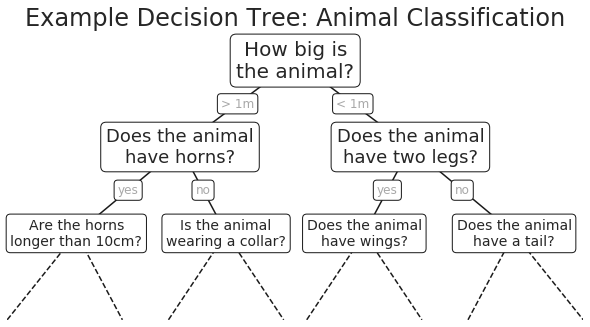

In [3]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_axes([0, 0, 0.8, 1], frameon=False, xticks=[], yticks=[])
ax.set_title('Example Decision Tree: Animal Classification', size=24)

def text(ax, x, y, t, size=20, **kwargs):
    ax.text(x, y, t,
            ha='center', va='center', size=size,
            bbox=dict(boxstyle='round', ec='k', fc='w'), **kwargs)

text(ax, 0.5, 0.9, "How big is\nthe animal?", 20)
text(ax, 0.3, 0.6, "Does the animal\nhave horns?", 18)
text(ax, 0.7, 0.6, "Does the animal\nhave two legs?", 18)
text(ax, 0.12, 0.3, "Are the horns\nlonger than 10cm?", 14)
text(ax, 0.38, 0.3, "Is the animal\nwearing a collar?", 14)
text(ax, 0.62, 0.3, "Does the animal\nhave wings?", 14)
text(ax, 0.88, 0.3, "Does the animal\nhave a tail?", 14)

text(ax, 0.4, 0.75, "> 1m", 12, alpha=0.4)
text(ax, 0.6, 0.75, "< 1m", 12, alpha=0.4)

text(ax, 0.21, 0.45, "yes", 12, alpha=0.4)
text(ax, 0.34, 0.45, "no", 12, alpha=0.4)

text(ax, 0.66, 0.45, "yes", 12, alpha=0.4)
text(ax, 0.79, 0.45, "no", 12, alpha=0.4)

ax.plot([0.3, 0.5, 0.7], [0.6, 0.9, 0.6], '-k')
ax.plot([0.12, 0.3, 0.38], [0.3, 0.6, 0.3], '-k')
ax.plot([0.62, 0.7, 0.88], [0.3, 0.6, 0.3], '-k')
ax.plot([0.0, 0.12, 0.20], [0.0, 0.3, 0.0], '--k')
ax.plot([0.28, 0.38, 0.48], [0.0, 0.3, 0.0], '--k')
ax.plot([0.52, 0.62, 0.72], [0.0, 0.3, 0.0], '--k')
ax.plot([0.8, 0.88, 1.0], [0.0, 0.3, 0.0], '--k')
ax.axis([0, 1, 0, 1])

## Creating a decision tree

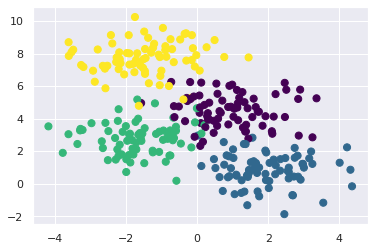

In [8]:
X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)
plt.scatter(X[:,0], X[:,1], c=y, s=50, cmap='viridis');

A simple decision tree build on this data will interactively split the data along one of the other axis according to some quantitative criterion.

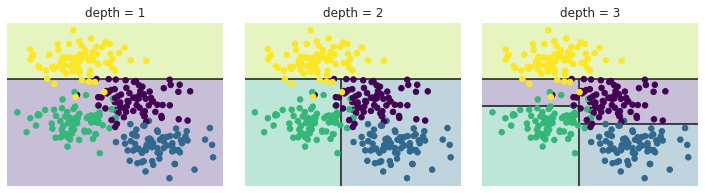

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)

for axi, depth in zip(ax, range(1, 4)):
    model = DecisionTreeClassifier(max_depth=depth)
    visualize_tree(model, X, y, ax=axi)
    axi.set_title('depth = {0}'.format(depth));

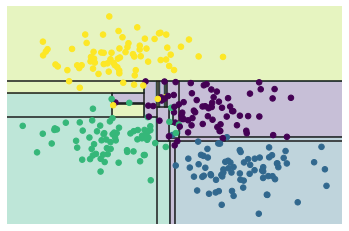

In [17]:
# without max_depth restrictions
dt = DecisionTreeClassifier()
visualize_tree(dt, X, y)

## Decision Trees Overfitting

Such overfitting turns out to be a general property of decision tres; it is very easy to go too deep in the tree, and thus end up fitting details particular to the analysed sample that might not general well with the overall distribution.

Another way to see overfitting is to look at model trained with different subsets of the same dataset.


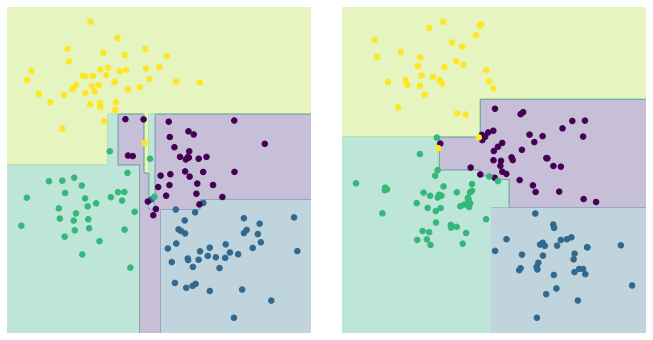

In [23]:
model = DecisionTreeClassifier()

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
visualize_tree(model, X[::2], y[::2], boundaries=False, ax=ax[0])
visualize_tree(model, X[1::2], y[1::2], boundaries=False, ax=ax[1])

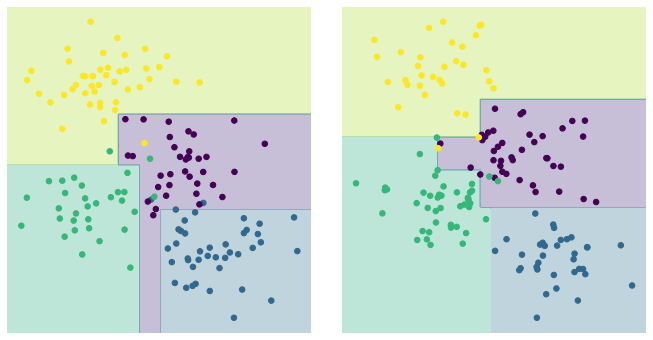

In [26]:
model = DecisionTreeClassifier(max_depth=4)

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
visualize_tree(model, X[::2], y[::2], boundaries=False, ax=ax[0])
visualize_tree(model, X[1::2], y[1::2], boundaries=False, ax=ax[1])

We can identify that our model consistently produces some similar regions, while there are some regions that are unique to an spefic model. 

**The key observation is that inconsistencies tend to happen where the classification is less certain. We might be able to conbine the results of different models, reduce those unceirtainties, and come up with a better model.**

**The sum could be better than it's parts.**

## Ensembles of Estimators: Random Forest

This notions, that multiple oferfitting estimators can be combined to reduce the effect of overfitting, is that underlies an ensemble method called bagging. Bagging makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which overfits the data combining the results to find a better model. ***An ensemble of randomized decision trees is know as random forest***.

This type of bagging classification can be done manually using sklearn's ``BaggingClassifier``.

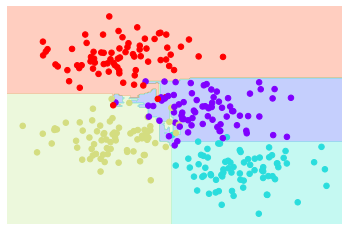

In [29]:
tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1)
bag.fit(X, y)
visualize_classifier(bag, X, y)

In the above example, we have randomized the data by fitting each estimator witha random subset of 80%. In practice, decision trees are more effective randomized by injecting some stochasticity in how the splits are chosen.

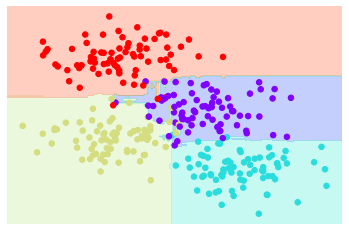

In [31]:
model = RandomForestClassifier(n_estimators=100, random_state=1)
visualize_classifier(model, X, y)

## Random Forest Regression

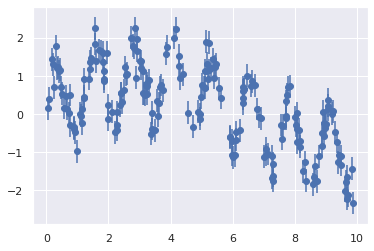

In [43]:
rng = np.random.RandomState(42)
X = 10 * rng.rand(200)

def model(data, sigma=0.3):
  fast_oscilation = np.sin(5 * data)
  slow_oscilation = np.sin(0.5 * data)
  noise = sigma * rng.randn(len(data))
  return slow_oscilation + fast_oscilation + noise

y = model(X)
plt.errorbar(X, y, 0.3, fmt='o');

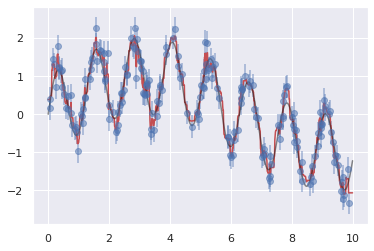

In [50]:
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)
x_fit = np.linspace(0, 10, 1000)
y_fit = forest.predict(x_fit[:, None])
y_true = model(x_fit, sigma=0)

plt.errorbar(X, y, 0.3, fmt='o', alpha=0.5)
plt.plot(x_fit, y_fit, '-r')
plt.plot(x_fit, y_true, '-k', alpha=0.5);

## Classifiying MNIST

In [52]:
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

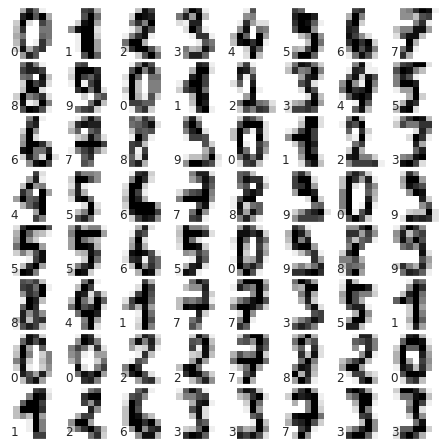

In [55]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(64):
  ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
  ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
  ax.text(0, 7, str(digits.target[i]));

In [58]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, 
                                                    digits.target,
                                                    random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        37
           1       0.98      0.98      0.98        43
           2       1.00      0.95      0.98        44
           3       0.98      0.98      0.98        45
           4       1.00      0.97      0.99        38
           5       0.96      0.98      0.97        48
           6       1.00      1.00      1.00        52
           7       0.96      1.00      0.98        48
           8       0.98      0.96      0.97        48
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



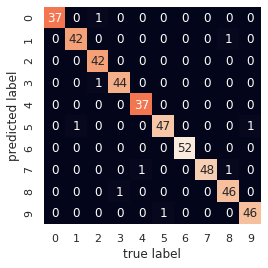

In [61]:
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');